# Data Analytics Programming - Projekt końcowy

Projekt automatyzuje proces zbierania danych ze strony Redfin dla miasta Chicago przy użyciu Selenium. Skrypt otwiera stronę z wynikami wyszukiwania, przełącza widok na tabelaryczny i pobiera kluczowe informacje o nieruchomościach, takie jak adres, lokalizacja, cena, liczba pokoi, powierzchnia, opłaty HOA oraz rok budowy. Na podstawie obecności opłaty HOA określa typ nieruchomości (Single Family Home lub Condo / Apartment). Skrypt automatycznie przechodzi na kolejne strony wyników i zapisuje zebrane dane do pliku CSV (redfin_data_chrome.csv). 



In [100]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
# Ścieżka do ChromeDriver na tym urządzeniu
CHROME_DRIVER_PATH = "/Users/aleksandragrygorczyk/bin/chromedriver"

# URL do strony Redfin
url = "https://www.redfin.com/city/29470/IL/Chicago"

# Ustawienia Chrome
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")  # Otwarcie w pełnym oknie
# options.add_argument("--headless")  # Tryb bez okna
options.add_argument("--disable-gpu")  # Wyłączenie GPU

service = Service(CHROME_DRIVER_PATH)
driver = webdriver.Chrome(service=service, options=options)
driver.get(url)
wait = WebDriverWait(driver, 5)

# 1. Kliknięcie "List"
list_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//div[contains(@class, 'SegmentedControl__option')][.//span[text()='List']]")))
list_button.click()

# 2. Zmiana opcji na "Table"
table_option = wait.until(EC.element_to_be_clickable((By.XPATH, "//select[@class='Select__nativeSelect']/option[@value='table']")))
table_option.click()

time.sleep(3)

data = []
current_page = 1
max_pages = 15

def get_table_data():
    rows = driver.find_elements(By.CLASS_NAME, "tableRow")
    for row in rows:
        try:
            row.click()
            time.sleep(1)
    
            address = row.find_element(By.CLASS_NAME, "col_address").text.strip()
            location = row.find_element(By.CLASS_NAME, "col_location").text.strip()
            price = row.find_element(By.CLASS_NAME, "col_price").text.strip()
            beds = row.find_element(By.CLASS_NAME, "col_beds").text.strip()
            baths = row.find_element(By.CLASS_NAME, "col_baths").text.strip()
            sqft = row.find_element(By.CLASS_NAME, "col_sqft").text.strip()
            pp_sqft = row.find_element(By.CLASS_NAME, "col_ppsqft").text.strip()

            hoa = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//li[span[text()='HOA']]/span[@data-rf-test-name='homecard-amenities-hoa']"))
            ).text.strip()

            year_built = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//li[span[text()='Year Built']]/span[@data-rf-test-name='homecard-amenities-year-built']"))
            ).text.strip()
            
            if not hoa or hoa.lower() in ['none', '', 'na']:
                property_type = "Single Family Home"
            else:
                property_type = "Condo / Apartment"

            data.append({
                "Address": address,
                "Location": location,
                "Price": price,
                "Beds": beds,
                "Baths": baths,
                "SqFt": sqft,
                "Price per sqft": pp_sqft,
                "HOA": hoa,
                "Year Built": year_built,
                "Property Type": property_type
            })
            
        except Exception:
            continue
            
            
while current_page <= max_pages:
    print(f"Pobieranie danych ze strony {current_page}...")
    
    get_table_data()

    try:
        next_button = wait.until(EC.element_to_be_clickable(
            (By.XPATH, "//button[contains(@class, 'PageArrow__direction--next')]")
        ))
        next_button.click()
        time.sleep(2)

    except Exception:
        break

    current_page += 1

driver.quit()

df = pd.DataFrame(data)
print(df)

df.to_csv("redfin_data_chrome.csv", index=False)

Pobieranie danych ze strony 1...
Pobieranie danych ze strony 2...
Pobieranie danych ze strony 3...
Pobieranie danych ze strony 4...
Pobieranie danych ze strony 5...
Pobieranie danych ze strony 6...
Pobieranie danych ze strony 7...
Pobieranie danych ze strony 8...
Pobieranie danych ze strony 9...
                            Address               Location       Price Beds  \
0                3110 W Belmont Ave         CHI - Avondale  $3,195,000   18   
1          1000 E 53rd St Unit 519S      Renaissance Place    $195,000    1   
2    4940 S East End Ave., Unit 10C                Chicago    $199,000    1   
3             5421 N Ravenswood Ave                Chicago    $879,900    3   
4            7840 S Springfield Ave          CHI - Ashburn    $249,900    3   
..                              ...                    ...         ...  ...   
232                530 N Paulina St        CHI - West Town  $1,289,000    3   
233      655 W Irving Park Rd #5306        CHI - Lake View    $195,000 

### Czyszczenie danych 
1.	Usunięcie wierszy z brakującymi kluczowymi wartościami:
    - Wiersze, w których Address jest pusty lub SqFt ma wartość —, zostały usunięte.
2. Usunięcie znaków specjalnych i konwersja wartości na liczby:
    - Wartości w kolumnach Price, SqFt, Price per sqft, oraz HOA zawierające symbole walutowe ($, przecinki, /month) zostały przekształcone na liczby zmiennoprzecinkowe.
    - Brakujące wartości w kolumnie HOA zostały skonwertowane na NaN
3.	Usunięcie wierszy z brakującymi wartościami:
    - Wiersze, w których kluczowe kolumny (SqFt, Baths) zawierały puste wartości, zostały usunięte.
4.	Zapisanie danych:
    - Oczyszczone dane zostały zapisane do nowego pliku CSV redfin_cleaned_data.csv.


In [86]:
file_path = "redfin_data_chrome.csv" 
df = pd.read_csv(file_path)

print("Podstawowe informacje o danych przed czyszczeniem:")
print(df.info())

# 1. Usuwanie wierszy, gdzie 'Address' jest pusty lub 'SqFt' ma wartość '—'
df = df[(df['Address'].notnull()) & (df['SqFt'] != '—')]

# 2. Usuwanie znaków specjalnych i konwersja kolumn na liczby
df['Price'] = df['Price'].str.replace(r'[\$,]', '', regex=True).astype(float)
df['SqFt'] = df['SqFt'].str.replace(r',', '', regex=True).astype(float)
df['Price per sqft'] = df['Price per sqft'].str.replace(r'[\$,]', '', regex=True).astype(float)
df['HOA'] = df['HOA'].str.replace(r'[\$,/month]', '', regex=True)
df['HOA'] = pd.to_numeric(df['HOA'], errors='coerce')  # Na wypadek brakujących wartości

# 3. Usuwanie wierszy z brakującymi wartościami w kluczowych kolumnach
cleaned_df = df[
    (df['SqFt'].notnull()) &  # Powierzchnia nie jest pusta
    (df['Baths'].notnull())   # Liczba łazienek nie jest pusta
]

print("\nPodstawowe informacje o danych po czyszczeniu:")
print(cleaned_df.info())

cleaned_df.to_csv("redfin_cleaned_data.csv", index=False)
print("\nWyczyszczone dane zostały zapisane do pliku 'redfin_cleaned_data.csv'.")

Podstawowe informacje o danych przed czyszczeniem:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Address         237 non-null    object
 1   Location        237 non-null    object
 2   Price           237 non-null    object
 3   Beds            237 non-null    object
 4   Baths           237 non-null    object
 5   SqFt            237 non-null    object
 6   Price per sqft  237 non-null    object
 7   HOA             122 non-null    object
 8   Year Built      237 non-null    int64 
 9   Property Type   237 non-null    object
dtypes: int64(1), object(9)
memory usage: 18.6+ KB
None

Podstawowe informacje o danych po czyszczeniu:
<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 0 to 236
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Address         1

### Podstawowa analiza statystyczna
Wykonano podstawową analizę statystyczną, która pokazuje m.in. średnią cenę, odchylenie standardowe oraz wartości minimalne i maksymalne dla nieruchomości. Dodatkowo wygenerowano histogram przedstawiający rozkład cen z estymacją gęstości, aby lepiej zobaczyć, jak ceny są rozłożone w danych.

Podstawowe statystyki:
             Price      SqFt  Price per sqft      HOA  Year Built
count       168.00    168.00          168.00    90.00      168.00
mean    485,297.39  1,678.04          288.05   744.44    1,953.79
std     498,974.26  1,447.29          139.48   472.04       39.16
min      53,900.00    527.00           55.00   165.00    1,885.00
25%     249,900.00  1,036.00          189.00   350.00    1,923.00
50%     332,500.00  1,295.00          265.00   695.00    1,953.50
75%     517,500.00  1,840.25          364.00   966.75    1,990.25
max   4,200,000.00 16,234.00          814.00 2,531.00    2,025.00


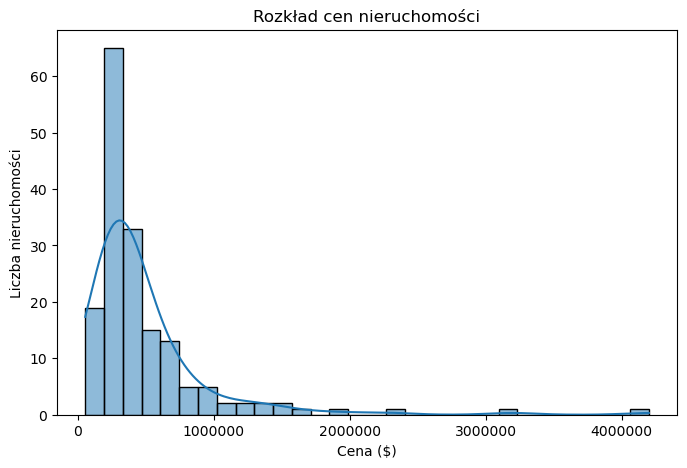

In [87]:
pd.options.display.float_format = '{:,.2f}'.format

# Podstawowa analiza statystyczna
print("Podstawowe statystyki:")
print(cleaned_df.describe())

plt.figure(figsize=(8, 5))
sns.histplot(cleaned_df['Price'], bins=30, kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.title("Rozkład cen nieruchomości")
plt.xlabel("Cena ($)")
plt.ylabel("Liczba nieruchomości")
plt.show()

### Analiza korelacji 
W tej części przeprowadzono analizę korelacji między wybranymi cechami nieruchomości: ceną (Price), liczbą sypialni (Beds), łazienek (Baths), powierzchnią (SqFt) oraz ceną za stopę kwadratową (Price per sqft). Wartości korelacji przedstawiono zarówno w formie tabeli, jak i na mapie cieplnej (heatmap).

Najsilniejsze zależności występują między powierzchnią a ceną, liczbą łazienek oraz ceną za stopę kwadratową.


Macierz korelacji:
                Price  Beds  Baths  SqFt  Price per sqft
Price            1.00  0.45   0.72  0.72            0.58
Beds             0.45  1.00   0.83  0.81           -0.23
Baths            0.72  0.83   1.00  0.92            0.08
SqFt             0.72  0.81   0.92  1.00            0.01
Price per sqft   0.58 -0.23   0.08  0.01            1.00


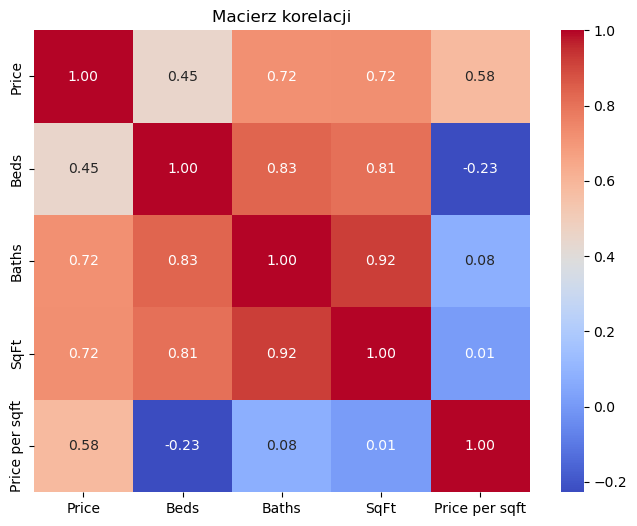

In [88]:
correlation_matrix = cleaned_df[['Price', 'Beds', 'Baths', 'SqFt', 'Price per sqft']].corr()
print("Macierz korelacji:")
print(correlation_matrix)

# Wizualizacja korelacji
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Macierz korelacji")
plt.show()

W tej analizie obliczono średnie ceny nieruchomości dla różnych lokalizacji. Wyniki zostały posortowane malejąco, aby zidentyfikować obszary o najwyższych i najniższych cenach.

Wizualizacja w postaci wykresu słupkowego pokazuje różnice cen między lokalizacjami. Dzięki niej można łatwo zauważyć, które dzielnice charakteryzują się wyższą średnią ceną,


Średnia cena nieruchomości dla lokalizacji:
Location
Southport Corridor    4,200,000.00
CHI - Avondale        1,561,666.67
Trump Tower Chicago   1,495,000.00
CHI - Logan Square    1,284,500.00
CHI - North Center    1,150,000.00
                          ...     
CHI - Uptown            190,900.00
CHI - Roseland          188,000.00
CHI - West Pullman      180,600.00
CHI - Chatham           179,950.00
CHI - North Park        149,900.00
Name: Price, Length: 75, dtype: float64


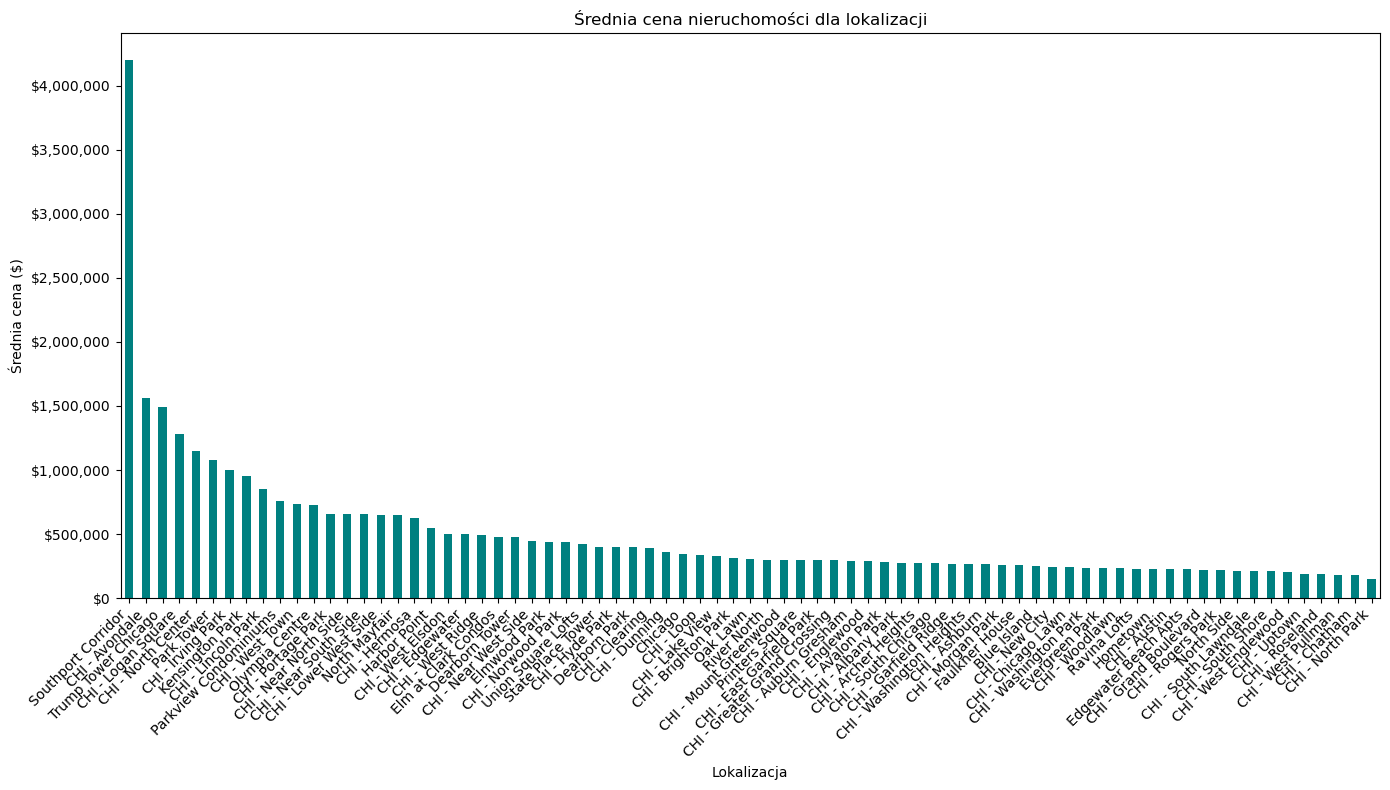

In [101]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

grouped_full_locations = (
    cleaned_df.groupby('Location')['Price']
    .mean()
    .sort_values(ascending=False)
)

print("\nŚrednia cena nieruchomości dla lokalizacji:")
print(grouped_full_locations)

def format_price(x, pos):
    return f'${int(x):,}'

plt.figure(figsize=(14, 8))
grouped_full_locations.plot(kind='bar', color='teal')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_price))
plt.title("Średnia cena nieruchomości dla lokalizacji")
plt.ylabel("Średnia cena ($)")
plt.xlabel("Lokalizacja")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Wykres punktowy przedstawia zależność między powierzchnią nieruchomości a jej ceną, z podziałem na typy nieruchomości. Dzięki kolorom można łatwo porównać, jak różnią się zależności dla różnych typów – domów jednorodzinnych i mieszkań. Widać, że większe nieruchomości mają tendencję do wyższych cen, choć zależność ta nie jest liniowa.

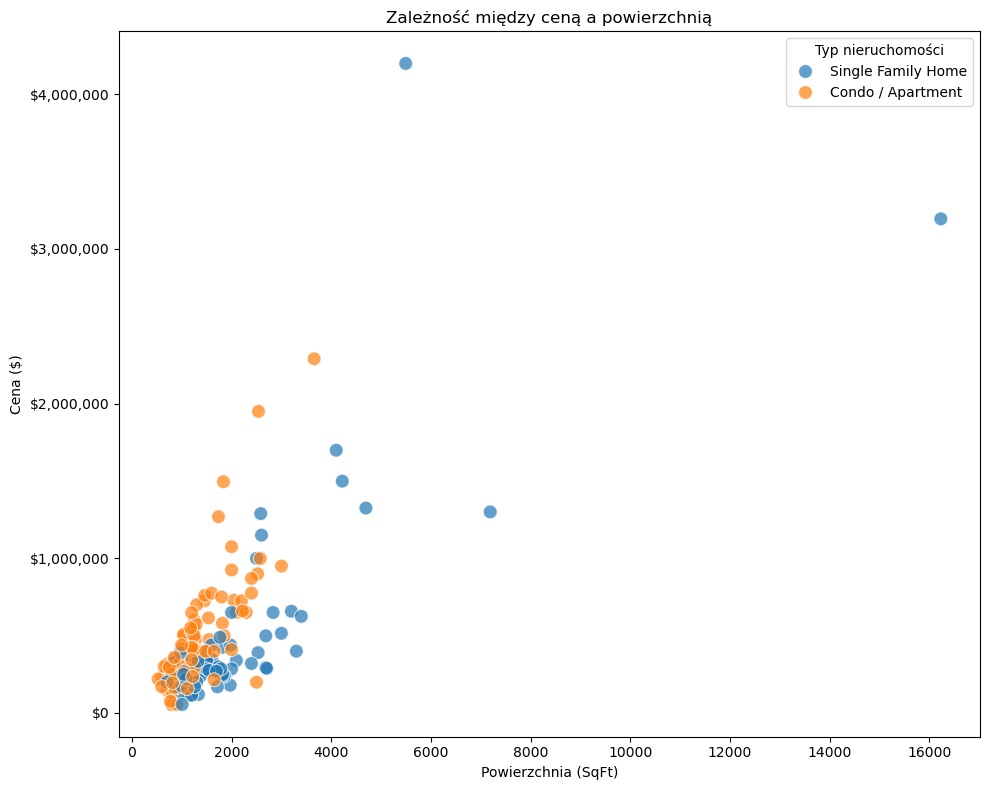

In [93]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='SqFt', y='Price', hue='Property Type', data=cleaned_df, s=100, alpha=0.7)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_price))
plt.title("Zależność między ceną a powierzchnią")
plt.xlabel("Powierzchnia (SqFt)")
plt.ylabel("Cena ($)")
plt.legend(title="Typ nieruchomości")
plt.tight_layout()
plt.show()

Przygotowujemy dane do dalszego modelowania, dokonując wyboru cech i celu predykcji oraz dzieląc zbiór danych na zestawy treningowy i testowy.

In [94]:
from sklearn.model_selection import train_test_split

# Wybór cech i celu 
features = ['Beds', 'Baths', 'SqFt', 'Price per sqft', 'HOA']
X = cleaned_df[features].fillna(0)
y = cleaned_df['Price']

# Podział na zbiory treningowy (80%) i testowy (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Liczba próbek w zbiorze treningowym: {len(X_train)}")
print(f"Liczba próbek w zbiorze testowym: {len(X_test)}")

Liczba próbek w zbiorze treningowym: 134
Liczba próbek w zbiorze testowym: 34


Tworzymy i trenujemy dwa modele uczenia maszynowego do przewidywania ceny nieruchomości, wykorzystując zbiór danych treningowych.
1. Model regresji liniowej - zakłada on, że istnieje liniowa zależność między cechami a zmienną docelową.
2. Model lasu losowego – jest to model zespołowy, który tworzy wiele niezależnych drzew decyzyjnych. Każde drzewo otrzymuje losowy podzbiór danych oraz cech, a jego predykcje są później uśredniane. Dzięki tej technice model jest bardziej odporny na wartości odstające oraz zjawisko przeuczenia

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Regresja liniowa
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

print("Modele zostały wytrenowane.")

Modele zostały wytrenowane.


In [96]:
# Przewidywanie dla zbioru testowego
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("Przewidywania zakończone.")

Przewidywania zakończone.


### Ocena modeli
Metryki oceny:
1. R² (współczynnik determinacji):
    - Wskazuje, jak dobrze model wyjaśnia zmienność danych.
    - Wartość bliska 1 oznacza dobre dopasowanie, natomiast niskie wartości wskazują na niedopasowanie modelu.
2. MAE (Mean Absolute Error):
    - Średnia różnica między rzeczywistymi a przewidywanymi wartościami.
    - Pokazuje przeciętny błąd predykcji w jednostkach docelowych.
3. RMSE (Root Mean Squared Error):
    - Pierwiastek z średniej kwadratowej różnicy między przewidywanymi a rzeczywistymi wartościami.
    - RMSE jest bardziej wrażliwe na duże błędy niż MAE, co pozwala lepiej ocenić, jak duże wartości odstające wpływają na model.
 

In [98]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print(f"R²: {r2_score(y_true, y_pred):.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):,.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")

evaluate_model(y_test, y_pred_lr, "Regresja Liniowa")
evaluate_model(y_test, y_pred_rf, "Random Forest")


Model: Regresja Liniowa
R²: 0.88
MAE: 119,492.75
RMSE: 176057.58

Model: Random Forest
R²: 0.82
MAE: 79,204.87
RMSE: 211450.19


#### Analiza ważności cech w modelu Random Forest
Analizujemy wpływ poszczególnych cech na przewidywania modelu Random Forest, w celu zrozumienia, które zmienne mają największy wpływ na cenę nieruchomości.


Ważność cech w Random Forest:
          Feature  Importance
2            SqFt        0.40
3  Price per sqft        0.27
1           Baths        0.26
0            Beds        0.05
4             HOA        0.02


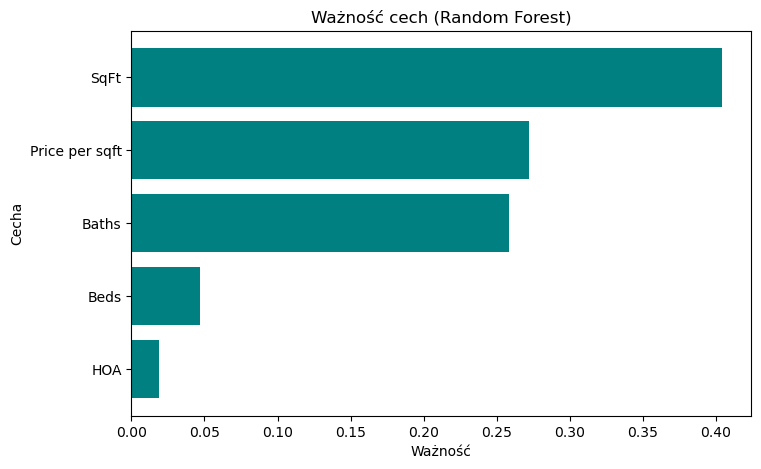

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print("\nWażność cech w Random Forest:")
print(importance_df)

plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.title("Ważność cech (Random Forest)")
plt.xlabel("Ważność")
plt.ylabel("Cecha")
plt.gca().invert_yaxis()
plt.show()

### Podsumowanie
1. Analiza statystyczna
    - Średnia cena nieruchomości wynosi około 410,621 USD, przy czym ceny wahają się od 54,900 USD do 2,290,000 USD.
    - Powierzchnia nieruchomości jest średnio na poziomie 1,444 stóp kwadratowych.
2. Analiza rozkładu cen
    - Rozkład cen jest asymetryczny – większość nieruchomości znajduje się w przedziale cenowym od 200,000 do 600,000 USD, ale występują też wartości odstające powyżej 1 miliona USD.
3. Średnia cena nieruchomości w lokalizacjach
    - Zidentyfikowano lokalizacje o najwyższych i najniższych średnich cenach nieruchomości. Dzielnice takie jak CHI - Lincoln Park i CHI - Near North Side należą do najdroższych, podczas gdy CHI - South Shore charakteryzuje się znacznie niższymi cenami.
4. Analiza korelacji
    - Ceny są najsilniej skorelowane z cechą Price per sqft (r = 0.84) oraz powierzchnią nieruchomości SqFt (r = 0.62)
    - Liczba łazienek również wykazuje istotną korelację z ceną (r = 0.53), co sugeruje, że większe i bardziej funkcjonalne nieruchomości są droższe.
    - Liczba sypialni ma bardzo słabą korelację z ceną (r = 0.03), co wskazuje, że sama liczba pokoi nie wpływa znacząco na wartość nieruchomości.
5. Modelowanie i ocena wyników: 
Wyniki pokazują, że model regresji liniowej osiągnął wyższy współczynnik determinacji R² (0.88), ale generuje wyższy średni błąd absolutny (119,492.75 USD). Z kolei model Random Forest lepiej radził sobie z typowymi błędami (MAE: 79,204.87 USD), jednak miał większe problemy z wartościami odstającymi, co skutkowało wyższym RMSE (211,450.19 USD).


